<a href="https://colab.research.google.com/github/amanu242006/FAC-task-3/blob/main/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Found subfolders: ['01Jan-Nifty', '02Feb-Nifty', '03Mar-Nifty', '04Apr-Nifty', '05May-Nifty', '06June-Nifty', '07July-Nifty', '08Aug-Nifty', '09Sept-Nifty', '10Oct-Nifty', '11Nov-Nifty', '12Dec-Nifty']

 Processing folder: 01Jan-Nifty

 Processing folder: 02Feb-Nifty

 Processing folder: 03Mar-Nifty

 Processing folder: 04Apr-Nifty

 Processing folder: 05May-Nifty

 Processing folder: 06June-Nifty
 Error processing 18200: No columns to parse from file

 Processing folder: 07July-Nifty

 Processing folder: 08Aug-Nifty

 Processing folder: 09Sept-Nifty

 Processing folder: 10Oct-Nifty

 Processing folder: 11Nov-Nifty

 Processing folder: 12Dec-Nifty

 Summary Report
Total Trades: 569
 Winning Trades: 261
 Losing Trades: 308
 Average PnL: 3601.82
 Net PnL: 2049435.0
 Trades by Month:
 Month
12Dec-Nifty     120
09Sept-Nifty     74
10Oct-Nifty      72
02Feb-Nifty

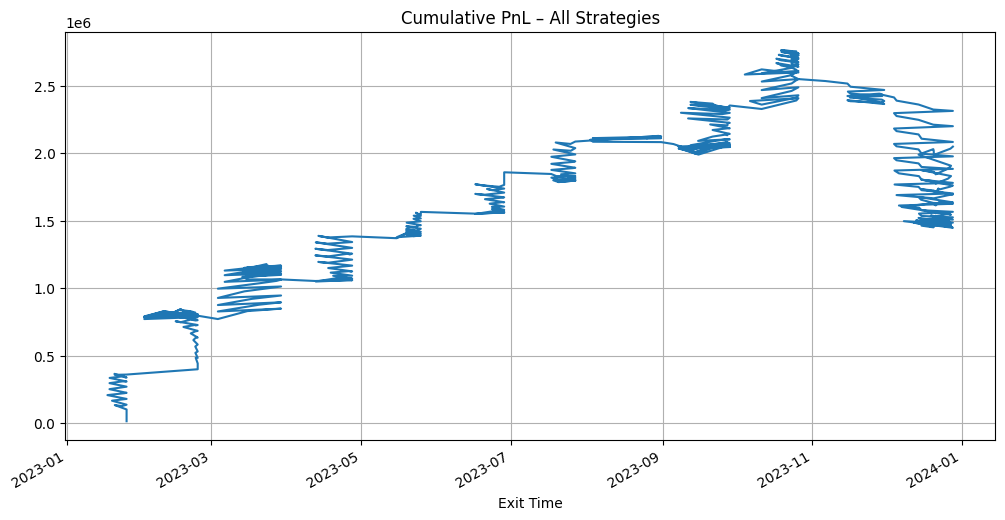

In [27]:


# Step 1: Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Imports
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Step 3: Setting paths
spot_path = "/content/drive/MyDrive/OptionBacktest2023/NIFTY2023/NIFTY_cash.csv"
option_base_path = "/content/drive/MyDrive/OptionBacktest2023"

# Step 4: Loading Spot Data from NIFTY2023
spot_df = pd.read_csv(spot_path, parse_dates=["datetime"])
spot_df = spot_df[["datetime", "close"]].rename(columns={"close": "spot_price"})
spot_df["spot_price"] = pd.to_numeric(spot_df["spot_price"], errors="coerce")

# Step 5: ExtractING Expiry Date
def extract_expiry_from_filename(path):
    match = re.search(r'(\d{4}-\d{2}-\d{2})', path)
    if match:
        return pd.to_datetime(match.group(1))
    return None

# Step 6: Loading All Matching Strikes per Month
all_trades = []

def load_strike_pairs(folder):
    call_files = glob.glob(os.path.join(folder, "*_call_*.json"))
    put_files = glob.glob(os.path.join(folder, "*_put_*.csv"))

    call_map = {re.search(r'(\d+)_call', os.path.basename(f)).group(1): f for f in call_files}
    put_map = {re.search(r'(\d+)_put', os.path.basename(f)).group(1): f for f in put_files}

    common_strikes = sorted(set(call_map.keys()) & set(put_map.keys()))
    expiry = extract_expiry_from_filename(call_files[0]) if call_files else None
    return [(strike, call_map[strike], put_map[strike], expiry) for strike in common_strikes]

# Step 7: Strategy Function (All Variants)
def run_strategy(df, expiry_date, sl_pct=0.25, tp_pct=0.5, atr_threshold=2):
    trades = []
    position = None
    entry_price = None
    entry_time = None
    position_type = None

    for i in range(1, len(df)):
        row = df.iloc[i]
        current_time = row.name
        spot = row['spot_price']

        if row['ATR'] < atr_threshold:
            continue

        atm_strike = row['strike']
        otm_call_strike = atm_strike + 200
        otm_put_strike = atm_strike - 200
        deep_otm_call_strike = atm_strike + 400
        deep_otm_put_strike = atm_strike - 400

        otm_call_row = df[(df.index == current_time) & (df['strike'] == otm_call_strike)]
        otm_put_row = df[(df.index == current_time) & (df['strike'] == otm_put_strike)]
        deep_otm_call_row = df[(df.index == current_time) & (df['strike'] == deep_otm_call_strike)]
        deep_otm_put_row = df[(df.index == current_time) & (df['strike'] == deep_otm_put_strike)]

        straddle_premium = row['call_price'] + row['put_price']
        strangle_premium = None
        butterfly_call_debit = None
        butterfly_put_debit = None
        short_butterfly_call_credit = None
        short_butterfly_put_credit = None
        ratio_call_debit = None
        ratio_put_debit = None

        if not otm_call_row.empty and not otm_put_row.empty:
            strangle_premium = otm_call_row['call_price'].values[0] + otm_put_row['put_price'].values[0]

        if not deep_otm_call_row.empty and not otm_call_row.empty:
            butterfly_call_debit = deep_otm_call_row['call_price'].values[0] + row['call_price'] - 2 * otm_call_row['call_price'].values[0]
            short_butterfly_call_credit = 2 * otm_call_row['call_price'].values[0] - (deep_otm_call_row['call_price'].values[0] + row['call_price'])
            ratio_call_debit = row['call_price'] - otm_call_row['call_price'].values[0] * 2

        if not deep_otm_put_row.empty and not otm_put_row.empty:
            butterfly_put_debit = deep_otm_put_row['put_price'].values[0] + row['put_price'] - 2 * otm_put_row['put_price'].values[0]
            short_butterfly_put_credit = 2 * otm_put_row['put_price'].values[0] - (deep_otm_put_row['put_price'].values[0] + row['put_price'])
            ratio_put_debit = row['put_price'] - otm_put_row['put_price'].values[0] * 2

        if position:
            current_premium = {
                "straddle": straddle_premium,
                "strangle": strangle_premium,
                "long_call_butterfly": butterfly_call_debit,
                "long_put_butterfly": butterfly_put_debit,
                "short_call_butterfly": short_butterfly_call_credit,
                "short_put_butterfly": short_butterfly_put_credit,
                "ratio_call_spread": ratio_call_debit,
                "ratio_put_spread": ratio_put_debit
            }.get(position_type, straddle_premium)

            exit_due_to_sl_tp = (
                position == "long" and (current_premium >= entry_price * (1 + tp_pct) or current_premium <= entry_price * (1 - sl_pct))
            ) or (
                position == "short" and (current_premium <= entry_price * (1 - tp_pct) or current_premium >= entry_price * (1 + sl_pct))
            )

            force_exit = current_time.date() >= expiry_date.date()

            if exit_due_to_sl_tp or force_exit:
                pnl = ((current_premium - entry_price) if position == "long" else (entry_price - current_premium)) * 100
                trades.append({
                    "Entry Time": entry_time,
                    "Entry Date": entry_time.date(),
                    "Exit Time": current_time,
                    "Position": position.title(),
                    "Strategy": position_type,
                    "Strike": atm_strike,
                    "Entry Price": entry_price,
                    "Exit Price": current_premium,
                    "PnL": pnl,
                    "Forced Exit": force_exit
                })
                position = None

        if not position and current_time.date() < expiry_date.date():
            if spot > row['Upper_Band'] and strangle_premium:
                position = "long"
                entry_price = strangle_premium
                entry_time = current_time
                position_type = "strangle"
            elif spot < row['Lower_Band']:
                position = "short"
                entry_price = straddle_premium
                entry_time = current_time
                position_type = "straddle"
            elif butterfly_call_debit and butterfly_call_debit < straddle_premium:
                position = "long"
                entry_price = butterfly_call_debit
                entry_time = current_time
                position_type = "long_call_butterfly"
            elif butterfly_put_debit and butterfly_put_debit < straddle_premium:
                position = "long"
                entry_price = butterfly_put_debit
                entry_time = current_time
                position_type = "long_put_butterfly"
            elif short_butterfly_call_credit and short_butterfly_call_credit > 0:
                position = "short"
                entry_price = short_butterfly_call_credit
                entry_time = current_time
                position_type = "short_call_butterfly"
            elif short_butterfly_put_credit and short_butterfly_put_credit > 0:
                position = "short"
                entry_price = short_butterfly_put_credit
                entry_time = current_time
                position_type = "short_put_butterfly"
            elif ratio_call_debit:
                position = "long"
                entry_price = ratio_call_debit
                entry_time = current_time
                position_type = "ratio_call_spread"
            elif ratio_put_debit:
                position = "long"
                entry_price = ratio_put_debit
                entry_time = current_time
                position_type = "ratio_put_spread"

    return pd.DataFrame(trades) if trades else pd.DataFrame([])

# Step 8: Backtest
subfolders = sorted([
    f.path for f in os.scandir(option_base_path)
    if f.is_dir() and "NIFTY2023" not in f.name
])
print(" Found subfolders:", [os.path.basename(f) for f in subfolders])

for folder in subfolders:
    print(f"\n Processing folder: {os.path.basename(folder)}")
    strike_pairs = load_strike_pairs(folder)

    for strike, call_file, put_file, expiry in strike_pairs:
        try:
            if os.stat(call_file).st_size == 0 or os.stat(put_file).st_size == 0:
                print(f"⚠️ Skipping strike {strike} due to empty file.")
                continue

            call_raw = pd.read_json(call_file)
            call_df = pd.DataFrame(call_raw["Success"].tolist())
            call_df = call_df[["datetime", "strike_price", "close"]].rename(columns={"close": "call_price", "strike_price": "strike"})
            call_df["datetime"] = pd.to_datetime(call_df["datetime"])
            call_df["strike"] = call_df["strike"].astype(int)
            call_df["call_price"] = pd.to_numeric(call_df["call_price"], errors="coerce")

            put_df = pd.read_csv(put_file, parse_dates=["datetime"])
            put_df = put_df[["datetime", "strike_price", "close"]].rename(columns={"close": "put_price", "strike_price": "strike"})
            put_df["put_price"] = pd.to_numeric(put_df["put_price"], errors="coerce")
            put_df["strike"] = put_df["strike"].astype(int)

            df = call_df.merge(put_df, on=["datetime", "strike"], how="inner")
            df = df.merge(spot_df, on="datetime", how="inner")
            df.dropna(subset=["call_price", "put_price", "spot_price"], inplace=True)
            df.set_index("datetime", inplace=True)

            df['H-L'] = df['spot_price'].diff().abs()
            df['ATR'] = df['H-L'].rolling(window=10).mean()
            df['MA'] = df['spot_price'].rolling(window=10).mean()
            df['STD'] = df['spot_price'].rolling(window=10).std()
            df['Upper_Band'] = df['MA'] + 1.5 * df['STD']
            df['Lower_Band'] = df['MA'] - 1.5 * df['STD']

            trades = run_strategy(df, expiry)
            if not trades.empty:
                trades["Month"] = os.path.basename(folder)
                trades["Strike File"] = strike
                all_trades.append(trades)

        except Exception as e:
            print(f" Error processing {strike}: {e}")

# Step 9: Printing results
if all_trades:
    results = pd.concat(all_trades)
    results["Cumulative PnL"] = results["PnL"].cumsum()

    print("\n Summary Report")
    print("Total Trades:", len(results))
    print(" Winning Trades:", len(results[results['PnL'] > 0]))
    print(" Losing Trades:", len(results[results['PnL'] < 0]))
    print(" Average PnL:", round(results["PnL"].mean(), 2))
    print(" Net PnL:", round(results["PnL"].sum(), 2))
    print(" Trades by Month:\n", results["Month"].value_counts())
    print(" Strategy Breakdown:\n", results["Strategy"].value_counts())
    print(" Total PnL by Strategy:\n", results.groupby("Strategy")["PnL"].sum().sort_values(ascending=False))

    results.set_index("Exit Time")["Cumulative PnL"].plot(
        figsize=(12, 6), title="Cumulative PnL – All Strategies")
    plt.grid(True)
    plt.show()
else:
    print(" No trades executed across all months.")



